# Intermediate notebook 2: stellar rotation rates
Stars rotate. This feature is inherently linked to stellar formation — the molecular clouds from which stars form need only very slightly rotate, and conservation of angular momentum makes sure that the final, formed star rotates, as well.

The rotation rate of a star at a given point in time tells us about its evolution, its magnetic field, etc. Stellar light curves (time-series photometry) offers a glimpse into the rotation rates of these bodies. The core idea is that stars are not homogeneous; rather, they can have cooler spots on their surface that rotate in and out of view. The classical picture is of a large single spot that yields a sinusoidal light curve, as an observer detects fewer photons when the spot is in view. In reality, stars are not so ideal — they may have multiple spots at once, and these spots evolve over time. But the general idea remains: the periodicity of a light curve is related to its rotation rate.

In this notebook, we will work through the key mechanics of identifying a star’s rotation period from its TESS light curve. We will then apply this to a large population of stars to understand how rotation rates vary across the M dwarf population.

## Import Statements

* **numpy** is used for array manipulation.

* **matplotlib.pyplot** is used to display images and plot datasets.
* **lightkurve** allows us to easily interact with TESS light curves.


In [1]:
# arrays
import numpy as np

# unpacking files 
import tarfile

# fits
from astropy.io import fits
from astropy.utils.data import download_file

# plotting
import matplotlib.pyplot as plt
from matplotlib import ticker

# stella CNN functions
import stella

# keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers.convolutional import Convolution1D, MaxPooling1D

# sklearn for performance metrics
from sklearn import metrics

# lightkurve
from lightkurve.search import search_lightcurve

# from IPython import get_ipython
# get_ipython().run_line_magic('matplotlib', 'notebook')

# set random seed for reproducibility 
np.random.seed(42)

2023-07-06 13:50:09.609195: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-06 13:50:10.172717: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-06 13:50:10.173572: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 13:50:25.416632: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
file_url = 'https://archive.stsci.edu/hlsps/hellouniverse/hellouniverse_stella_500.tar.gz'

In [3]:
file = tarfile.open(download_file(file_url, cache=True))
file.extractall('.')
file.close() # be sure to close files when you're finished with them!

In [4]:
data_dir = './hellouniverse_stella_500/'
ds = stella.FlareDataSet(fn_dir=data_dir,
                         catalog=data_dir+'Guenther_2020_flare_catalog.txt')

Reading in training set files.


100%|██████████| 62/62 [00:00<00:00, 235.70it/s]

502 positive classes (flare)
1342 negative classes (no flare)
37.0% class imbalance



In [5]:
# remove lightcurves with NaNs from training, test and validation data
def remove_nans(input_data):
    '''Determine indices of files without NaNs'''

    idx = []
    for k in range(np.shape(input_data)[0]):
        if len(input_data[k, :, :][np.isnan(input_data[k, :, :])]) == 0:
            idx.append(k)
    # AS: how do we want to talk about functions? assume that people know how they work for the intermediate notebooks?
    return idx


# find indices in train, test and validation sets without NaNs
idx_train = remove_nans(ds.train_data)
idx_test = remove_nans(ds.test_data)
idx_val = remove_nans(ds.val_data)

ds.train_data = ds.train_data[idx_train]
ds.train_labels = ds.train_labels[idx_train]

ds.test_data = ds.test_data[idx_test]
ds.test_labels = ds.test_labels[idx_test]

ds.val_data = ds.val_data[idx_val]
ds.val_labels = ds.val_labels[idx_val]

In [6]:
# ticids = ['278779899', '139754153', '273418879', '52121469', '188580272', '394015919', '402104884']
ticids = ['234295610']


# for all the selected targets, pull the available lightcurves using the lightkurve package
sectors = [1, 2] # only consider the first few sectors
lcs = []
for name in ticids:
    lc = search_lightcurve(target='TIC'+name, mission='TESS', sector=sectors, author='SPOC')
    lc = lc.download_all()[0]

In [7]:
x = (lc.time.value - np.min(lc.time.value))
y = (np.ma.getdata(lc.flux.value))
yerr = (np.ma.getdata(lc.flux_err.value))

In [8]:
from astropy.timeseries import LombScargle
frequency, power = LombScargle(x, y, yerr).autopower()

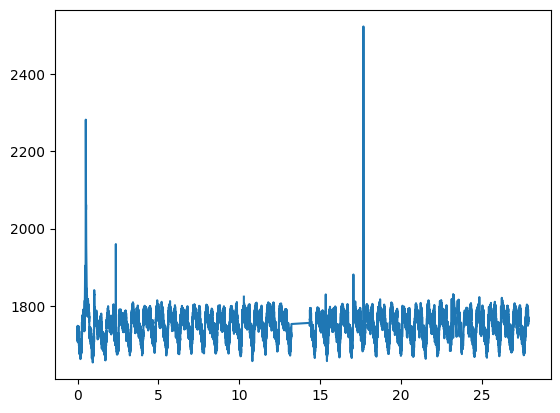

In [9]:
plt.plot(x,y)

Before we call the periodogram, we want to consider what a maximum period of the pulsations might be. TESS observes stars in a 28-day cadence (aside from those in the continuous viewing zone). Based on the Nyquist theorem (link and describe here), we only want to check for periodicity that's half as long as the observed basline. This way, we can catch two whole periods of the star.

DIFFERENCES from just a "basic" periodogram:
- treating the lightcurves "very nicely" to capture some of the secondary modes.
    - outlier rejection? how much do we hate that?
- talk about the harmonics.
- do we want to normalize? what do we gain, what do we lose?
- stitch together multiple sectors.

In [50]:
max_period=np.max(x)/2

In [51]:
pg = lc.normalize(unit='ppm').to_periodogram(maximum_period=max_period)

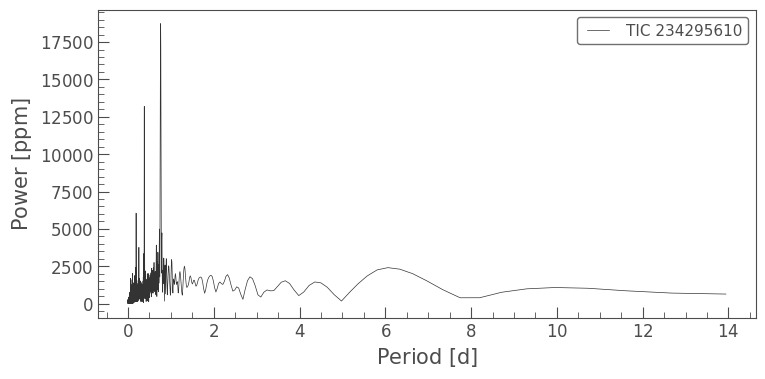

In [52]:
pg.plot();

We see some strong peaks already in just this single one. We haven't even performed any processing of our light curves!


 Let's plot this periodogram on a log time scale. What do we see? (Describe why there's more noise at the low-frequency end of things. Can we assign "proper" bins?)

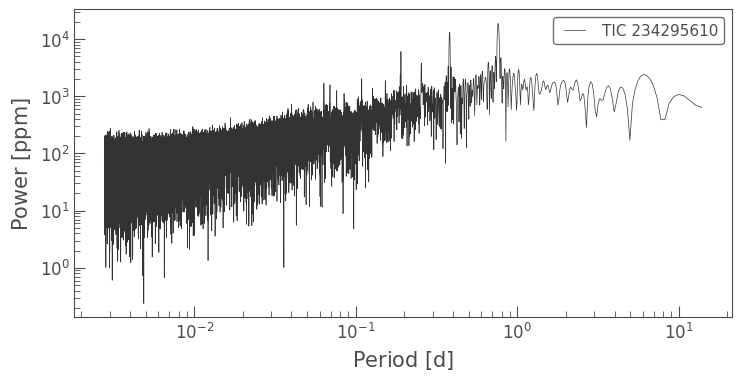

In [53]:
pg.plot(scale='log');


In [54]:
# then run it on many light curves at once. Compare to the flare rate derived in the previous notebook
# can we save the previous notebook somewhere else?

<Axes: xlabel='Period [$\\mathrm{d}$]', ylabel='Power [$\\mathrm{ppm}$]'>

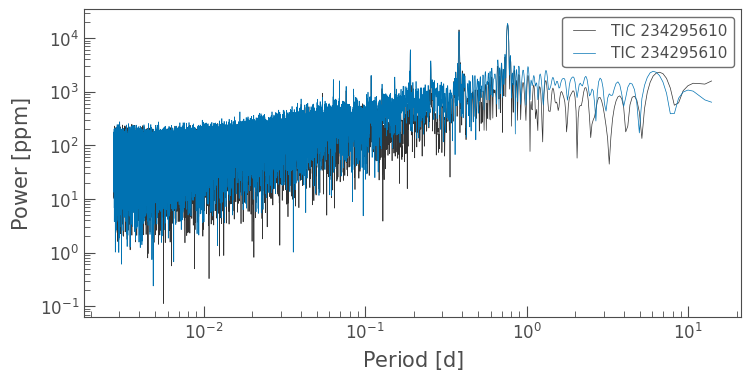

In [55]:
lc_clipped = lc.remove_outliers(sigma=3)

pg_clipped = lc_clipped.normalize(unit='ppm').to_periodogram(maximum_period=max_period)
ax = pg_clipped.plot(scale='log', zorder=1);

pg.plot(ax=ax, scale='log')

If we change this to just the 1-sigma outliers, the periodicity we're looking for is removed entirely.

<Axes: xlabel='Period [$\\mathrm{d}$]', ylabel='Power [$\\mathrm{ppm}$]'>

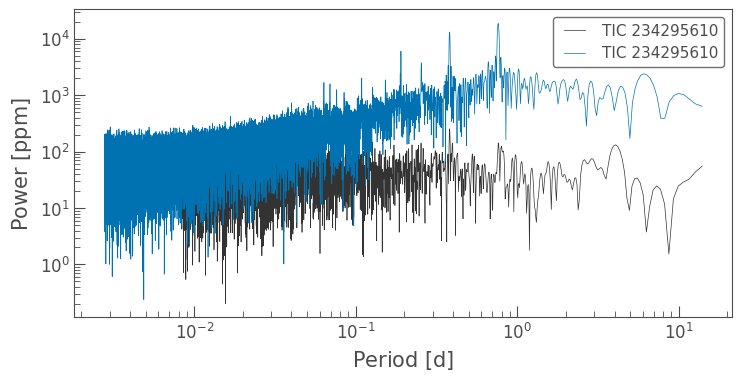

In [56]:
lc_clipped = lc.remove_outliers(sigma=1)

pg_clipped = lc_clipped.normalize(unit='ppm').to_periodogram(maximum_period=max_period)
ax = pg_clipped.plot(scale='log', zorder=1);

pg.plot(ax=ax, scale='log')

This makes sense when we take a look at the lightcurve that's been clipped.

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

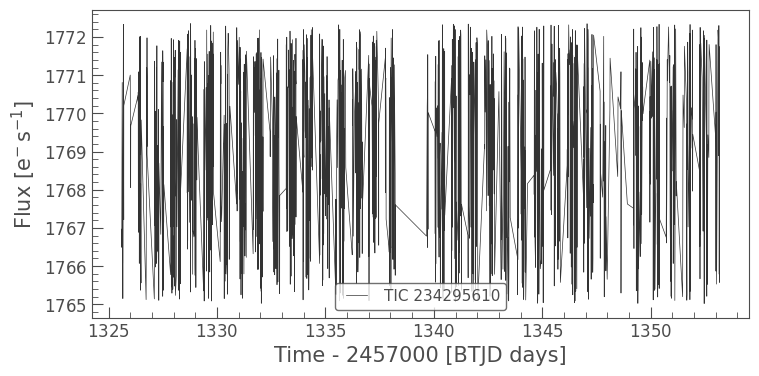

In [57]:
lc_clipped.plot()

We have clipped out so many data points (see the gaps) that there's not much coherent periodicity.

Now let's wrap our science in a function and apply it to a few other targets.

In [59]:
targets = ['38820496', '234295610', '177309964', '289840928', '201789285', '332517282', '206544316', 
           '425933644', '224283342', '425937691']

In [58]:
# Download the light curve data
search = lk.search_lightcurve('KIC 8197761', author='Kepler', cadence="long")
lc = search.download_all().stitch()

# Fold the light curve at the known planet period
planet_period = 9.8686667
lc.fold(period=planet_period).plot();

NameError: name 'lk' is not defined

In [57]:
# examine sensitivity to detrending

In [ ]:
# why difference between the two methods
# try a different light curve
# compare with flares